# **Grupo 6 - G2: Sistema de Recomendação - Aprendizado de Máquina**
#### Members: Thomas Botelho (1421500), Lucca Buffara (1521018), Niklas Gerlach, Maria Cruz

The purpose of this report is to create a recommendation system based on the Amazon Review dataset from 2018. This dataset contains millions of reviews from May 1996 to Oct 2018, from the Amazon website. The full uncompressed dataset, considering only production with 5 or more reviews, 

In [2]:
import os
import json
import gzip
import random
import pandas as pd
import seaborn as sns
from urllib.request import urlopen

In [3]:
GZIP_PATH = "Video_Games.json.gz"
METADATA_JSON_PATH = "VideoGames_meta.json"

def get_item(asin):
    return df_meta[df_meta['asin'].str.contains(asin)]

def get_recommendations(algo, uid):
    try:
        items_id = recommendations[algo][uid]
        return [get_item(item).head(1)['title'].iloc[0] for item in items_id]
    except KeyError:
        print("UID not found:", uid)

# Load metadata
with open(METADATA_JSON_PATH) as f:
    meta_json = json.load(f)

df_meta = pd.json_normalize(meta_json)

# Load data
data = []
with gzip.open(GZIP_PATH) as f:
    data.extend(json.loads(l.strip()) for l in f)
print(len(data))

# first row of the list
print(data[0])

2565349
{'overall': 1.0, 'verified': True, 'reviewTime': '06 9, 2014', 'reviewerID': 'A21ROB4YDOZA5P', 'asin': '0439381673', 'reviewerName': 'Mary M. Clark', 'reviewText': 'I used to play this game years ago and loved it. I found this did not work on my computer even though it said it would work with Windows 7.', 'summary': 'Did not like this', 'unixReviewTime': 1402272000}


In [13]:
# Sort by date
data = sorted(data, key=lambda x: x['unixReviewTime'])

# Remove unwanted fields
for entry in data:
    if 'reviewTime' in entry:
        del entry['reviewTime']
    if 'style' in entry:
        del entry['style']
    if 'reviewerName' in entry:
        del entry['reviewerName']
    if 'reviewText' in entry:
        del entry['reviewText']
    if 'summary' in entry:
        del entry['summary']
    if 'image' in entry:
        del entry['image']

df = pd.DataFrame.from_dict(data)
df[['vote']] = df[['vote']].fillna(value=0)
df.head()

# Number of reviews per product
df.groupby(['asin']).count()['overall']

overall_count = pd.DataFrame(df['overall'].value_counts()).reset_index()
overall_count.columns = ['overall', 'count']
overall_count

,overall,count
0,5.0,1487366
1,4.0,412413
2,1.0,311891
3,3.0,212346
4,2.0,141333


Text(0.5, 1.0, 'Popular Products Bar Chart')

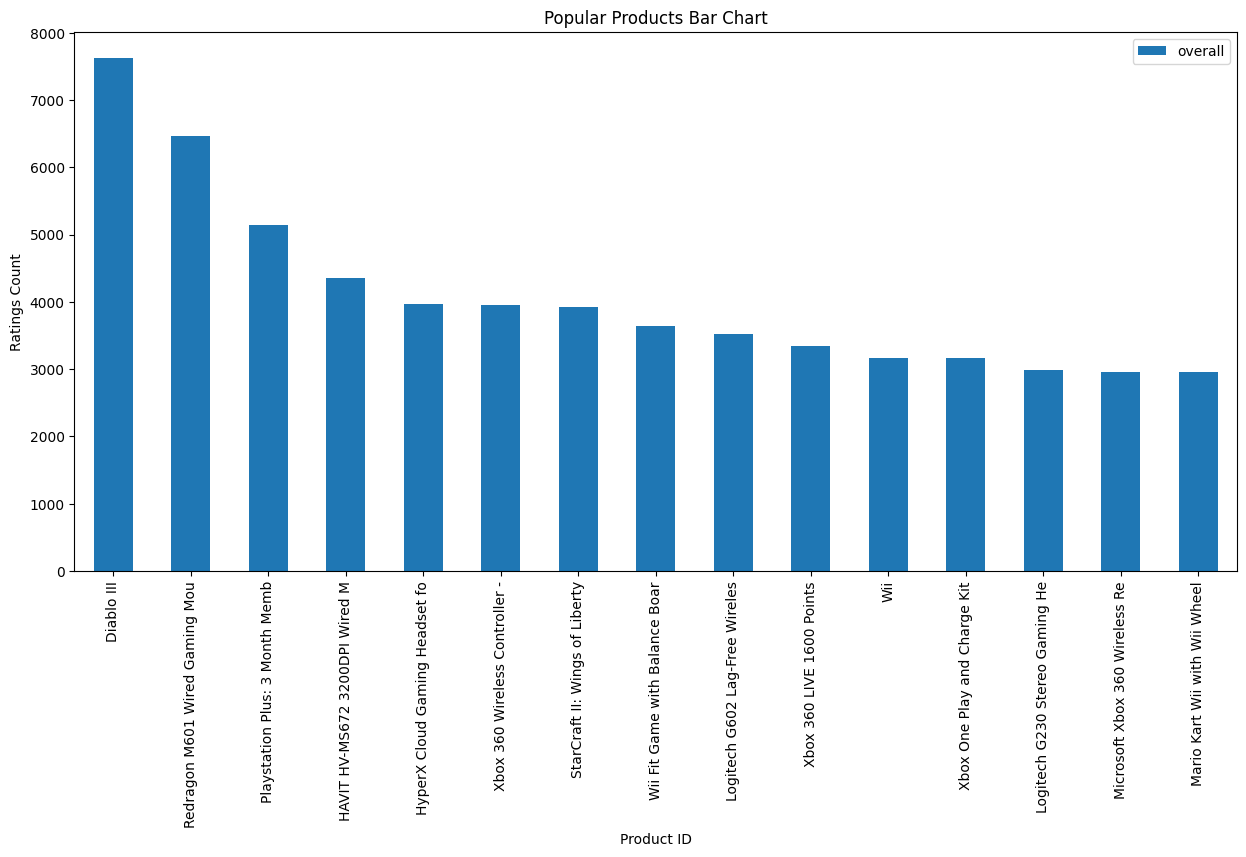

In [14]:
# Get popular products -- Products that have more than 1k reviews
popular_data = df.groupby("asin").filter(lambda x:x['overall'].count() >= 1000)
popular_products = pd.DataFrame(popular_data.groupby('asin')['overall'].count())
popular_products = popular_products.sort_values('overall', ascending=False)

dat = popular_products.head(15).reset_index()
dat["names"] = dat["asin"]
dat = dat.set_index("asin")
dat["names"] = dat["names"].apply(lambda x: get_item(x)["title"].values[0][:30])

ax = dat.plot(x = "names", y = "overall", kind = "bar", figsize=(15,7))
ax.set_xlabel("Product ID")
ax.set_ylabel("Ratings Count")
ax.set_title("Popular Products Bar Chart")

In [15]:
from surprise import SVD, SVDpp, CoClustering
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
from collections import defaultdict
from surprise.model_selection import GridSearchCV

cf_data = df[['reviewerID', 'asin', 'overall']]
display( cf_data.head() )

reader = Reader(rating_scale=(1, 5))

full_data = Dataset.load_from_df(cf_data, reader)
predict_data = full_data.build_full_trainset()
traindata, testdata = train_test_split(full_data, test_size=0.3)

,reviewerID,asin,overall
0,AR9HFLYSXUOYS,B00000JL6V,5.0
1,A26Y5BK10TL1OI,B00000JL6V,5.0
2,A3VMPX6KW6VSQY,B00000JL6V,5.0
3,A3N83WBSOG9PE4,B00000JL6V,1.0
4,A2Q6FRINMH0R81,B00000JL6V,4.0


In [16]:
# Build anti test set
fill = predict_data.global_mean

anti_testset = []
for u in traindata.all_users()[0:1]:
    user_items = {j for (j, _) in traindata.ur[u]}

    anti_testset += [
        (traindata.to_raw_uid(u), traindata.to_raw_iid(i), fill) for i in traindata.all_items() if i not in user_items ]

In [17]:
# Fit prediction algos
predict_algos = {
    "svd": SVD(n_epochs=30),
    "svdpp": SVDpp(n_factors=25, n_epochs=30),
    "co-clustering": CoClustering(n_epochs=35, n_cltr_u=8, n_cltr_i=8)
}

test_algos = predict_algos.copy()

for key, algo in predict_algos.items():
    predict_algos[key].fit(predict_data)
    test_algos[key].fit(traindata)

In [18]:
# Test algos
for algo in predict_algos.values():
    predict_svd = algo
    predict_svd.fit(predict_data)

prediction = dict.fromkeys(predict_algos)
test = dict.fromkeys(predict_algos)

for key, algo in predict_algos.items():
    prediction[key] = algo.test(anti_testset)
    test[key] = test_algos[key].test(testdata)

In [19]:
# Number of items rated by given user
def get_Iu(uid):
    try:
        return len(traindata.ur[traindata.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
# Number of users that have rated given item
def get_Ui(iid):
    try: 
        return len(traindata.ir[traindata.to_inner_iid(iid)])
    except ValueError:
        return 0

p_df = {}
for key, p in prediction.items():
    p_df[key] = pd.DataFrame(p, columns=['uid', 'iid', 'rui', 'est', 'details'])
    p_df[key]['Iu'] = p_df[key].uid.apply(get_Iu)
    p_df[key]['Ui'] = p_df[key].iid.apply(get_Ui)
    p_df[key]['err'] = abs(p_df[key].est - p_df[key].rui)

# RMSE
for key, res in test.items():
    print(key)
    accuracy.rmse(res, verbose=True)


svd
RMSE: 0.7242
svdpp
RMSE: 0.5502
co-clustering
RMSE: 0.6226


In [20]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = dict.fromkeys(predict_algos)
for key in prediction:
    top_n[key] = get_top_n(prediction[key], n=10)

for key, top in top_n.items():
    print(key)
    for uid, user_ratings in top.items():
        print("User ID:", uid, "Recommended items:", [iid for (iid, _) in user_ratings])

svd
User ID: A1H3PCW9L7KOF5 Recommended items: ['B017L187YG', 'B00005QEFD', 'B00AY1CT4U', 'B00WRJCRP8', 'B01GW3ODBU', 'B003O6JKLC', 'B00OVAB4P0', 'B00FAS1WDG', 'B00776UHG2', 'B00CX9L30W']
svdpp
User ID: A1H3PCW9L7KOF5 Recommended items: ['B015TL6PCQ', 'B015TL6PGM', 'B000B6MLSC', 'B01EO5QPN2', 'B008BKEWMI', 'B01EJ9DMQQ', 'B00RSXRLUE', 'B00KTNSLX6', 'B01AWGCO78', 'B00K1JBMDO']
co-clustering
User ID: A1H3PCW9L7KOF5 Recommended items: ['B0017135BW', 'B000BBRG5K', 'B00874B924', 'B00005LK73', 'B004IONDOO', 'B000ARPWXS', 'B000EB4T0M', 'B00005MA90', 'B0006VVOUS', 'B01CEY43C0']


In [21]:
# df_meta[['asin']]
recommendations = dict.fromkeys(predict_algos)
for key, top in top_n.items():
    recommendations[key] = {uid: [iid for (iid, _) in user_ratings] for uid, user_ratings in top.items()}
    random_user = random.choice(list(recommendations[key].keys()))
    print("Random user:",random_user)
    print("Recommendations")
    print( get_recommendations(key, random_user) )

Random user: A1H3PCW9L7KOF5
Recommendations
['Overwatch - Origins Edition - PC', 'GameCube (Jet Black)', 'Madden NFL 25 - Xbox 360', 'The Witcher 3: Wild Hunt - Expansion Pass - PlayStation 4 [Digital Code]', 'The Elder Scrolls V: Skyrim Special Edition - PS4 [Digital Code]', 'Xbox 360 4GB Console', 'FPS Freek Sentinel - 360/PS3', 'Xbox 360 Microsoft Authentic Wireless Pc Gaming Receiver for Windows (In Bulk Packaging)', 'Skylanders Adventure Case', "Final Fantasy XIV: A Realm Reborn Collector's Edition [Download]"]
Random user: A1H3PCW9L7KOF5
Recommendations
['Xbox One 1TB Console - 3 Games Holiday Bundle (Gears of War: Ultimate Edition + Rare Replay + Ori and the Blind Forest)', 'Xbox One 1 TB Console -  Fallout 4 Bundle', 'Xbox 360 Rechargeable Controller Battery Pack White', 'Matricom G-Pad XYBA Wireless Rechargeable Bluetooth Pro Game Pad Joystick Controller (Samsung Gear VR, PC, PS3, and G-Box Compatible!)', '30 Day Membership: RuneScape 3 [Instant Access]', 'Kootek Vertical Stan